# I'm making a new notebook for investigating the fraction of galaxies with photoz versus specz in the data

In [1]:
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy import units as u
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'stixgeneral'
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# read in the data
data_pth = '/Users/astro/Desktop/GitHub/satellite_fraction/data/'
data_file = data_pth + 's16a_massive_logmMax_11.45_z_0.25_0.47_mhalo_pdr_full.fits'

hdu1 = fits.open(data_file)
pdr_data= Table(hdu1[1].data)
pdr_data[0]

object_id,ra,dec,z_spec,z_best,z_phot,z_type,gcmodel_mag,gcmodel_mag_err,rcmodel_mag,rcmodel_mag_err,icmodel_mag,icmodel_mag_err,zcmodel_mag,zcmodel_mag_err,ycmodel_mag,ycmodel_mag_err,MSTAR,logm_10,logm_30,logm_100,logm_max,vdisp_sdss,vdisp_err_sdss,logms_gama,logms_err_gama,id_cluster_redm,p_mem_redm,z_lambda_redm,lambda_redm,p_cen_1_redm,id_camira,z_camira,n_cor_camira,logms_camira,r50_max,r50_100,logmh_peak,logmh_vir,logmh_host,ra_pdr,dec_pdr,sep_arcsec_pdr
int64,float64,float64,float64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
41584100993172458,339.30221049833926,-0.5047939798739985,0.25033000111579895,0.25033000111579895,nan,1,19.598822,0.0011392573,18.23641,0.0005367848,17.667036,0.00047776435,17.3642,0.0005285235,17.17294,0.0007222131,11.41357421875,11.288285695874468,11.449909889861537,11.512434451810856,11.515238377804888,239.67552185058594,19.472776412963867,nan,nan,-9999,nan,nan,nan,nan,-9999,nan,nan,nan,6.954138891157053,6.867189000762649,12.736635497686821,12.736635497686821,12.736635497686821,339.30221049833926,-0.5047939798740074,3.2203116149818104e-11


In [3]:
# constrain by total stellar mass
pdr_mass_cut = Table(names = pdr_data.colnames)
for i in range(len(pdr_data)):
    if pdr_data['logm_max'][i] > 11.5:
        pdr_mass_cut.add_row(pdr_data[i])

**Now comes the fun part**

I have to determine how many galaxies have only a photo-z and then plot the fraction of only photo-z and spec-z against the galaxy mass. Here I need to make use of the `np.isnan` function that Marie showed me. I think I want to use a histogram method like what we did when plotting the satellite fraction. Here is the way I'm thinking:
* 1) I will loop over the table and flag the ones with only photo-z
* 2) I will separate the galaxies into two tables based on the flags
* 3) Then perform histogram operation

In [4]:
# test np.isnan
pdr_no_specz = np.isnan(pdr_mass_cut['z_spec'])

In [5]:
# now just use that to make my new tables
pdr_photoz = Table(names = pdr_data.colnames)
pdr_specz = Table(names = pdr_data.colnames)

for i in range(len(pdr_mass_cut)):
    if pdr_no_specz[i] == False:
        pdr_specz.add_row(pdr_mass_cut[i])
    else:
        pdr_photoz.add_row(pdr_mass_cut[i])
z_frac = len(pdr_photoz)/len(pdr_specz)
print('Fraction of galaxies without spec-z =', z_frac)

Fraction of galaxies without spec-z = 0.09397303727200634


In [6]:
# place the data into histograms

specz_number, specz_edges = np.histogram(pdr_specz['logm_max'], bins = 12) # specz only
photoz_number, photoz_edges = np.histogram(pdr_photoz['logm_max'], bins = 12) # photoz only
z_tot, z_tot_edges = np.histogram(pdr_mass_cut['logm_max'], bins = 12) # all gals

bin_centers = (specz_edges[1:] + z_tot_edges[:-1]) / 2

# the important result

frac_specz = specz_number / z_tot



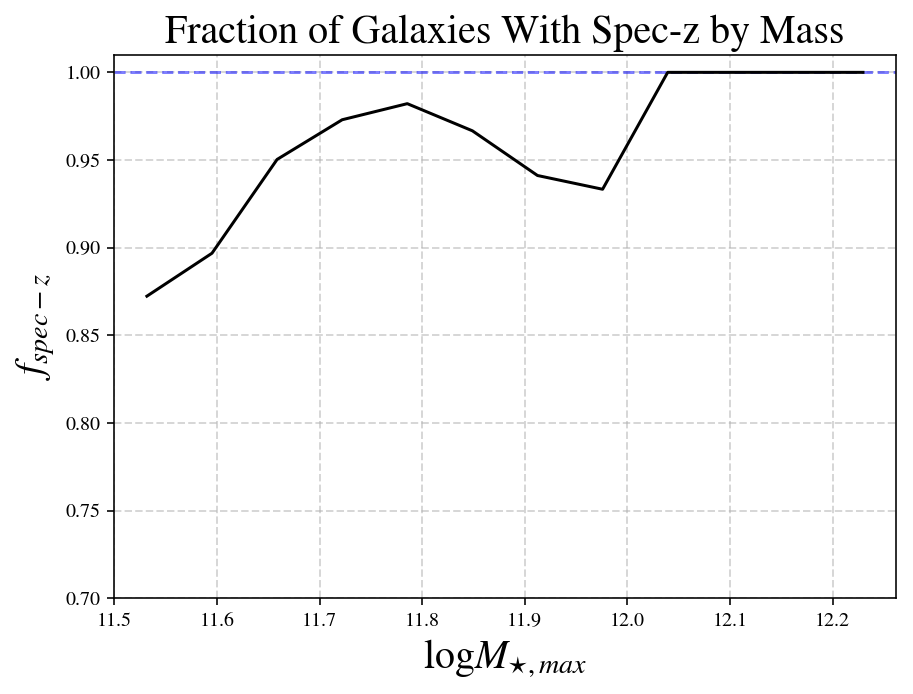

In [7]:
fig = plt.figure(figsize = [7,5])

ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)
ax1.plot([np.min(pdr_mass_cut['logm_max']), np.max(pdr_mass_cut['logm_max'])], 
         [1.0,1.0], color = 'blue', ls = '--', alpha = 0.5)
ax1.plot(bin_centers, frac_specz, color = 'k')
ax1.set_ylim(0.7,1.01)
ax1.set_xlim(np.min(pdr_mass_cut['logm_max']), np.max(pdr_mass_cut['logm_max']))
ax1.set_xlabel('$\log M_{\star, max}$', fontsize = 20)
ax1.set_ylabel('$f_{spec-z}$', fontsize = 20)
ax1.set_title('Fraction of Galaxies With Spec-z by Mass', fontsize = 20)

plt.savefig('specz_frac.eps', dpi = 1000)